In [115]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

In [ ]:
def sample0(sample_fpr, sample_tpr, curve_fpr, curve_tpr):
    if len(sample_fpr) == 0:
        return
    idx = np.random.choice(range(len(sample_fpr)))
    fpr_new = sample_fpr[idx]
    tpr_new = sample_tpr[idx]
    curve_fpr.append(fpr_new)
    curve_tpr.append(tpr_new)

    mask = (sample_fpr < fpr_new) & (sample_tpr < tpr_new)
    sample0(sample_fpr[mask], sample_tpr[mask], curve_fpr, curve_tpr)
    mask = (sample_fpr > fpr_new) & (sample_tpr > tpr_new)
    sample0(sample_fpr[mask], sample_tpr[mask], curve_fpr, curve_tpr)

def sample1(fprs, tprs, n_samples):
    curves_fpr = []
    curves_tpr = []

    for _ in range(n_samples):
        curve_fpr = []
        curve_tpr = []
        sample0(fprs, tprs, curve_fpr, curve_tpr)

        sorting = np.argsort(curve_fpr)
        curve_fpr = np.array(curve_fpr)[sorting]
        curve_tpr = np.array(curve_tpr)[sorting]

        curves_fpr.append((curve_fpr))
        curves_tpr.append((curve_tpr))
    
    return curves_fpr, curves_tpr

def sample2(fpr0, tpr0, p, n, n_samples):
    fprs = np.tile(np.linspace(0, 1, n), (p, 1)).reshape(p*n)
    tprs = np.tile(np.linspace(0, 1, p), (n, 1)).T.reshape(p*n)
    mask = tprs >= fprs
    fprs = fprs[mask]
    tprs = tprs[mask]

    mask_left = (fprs <= fpr0) & (tprs <= tpr0)
    mask_right = (fprs >= fpr0) & (tprs >= tpr0)
    curves_left_fpr, curves_left_tpr = sample1(fprs[mask_left], tprs[mask_left], n_samples)
    curves_right_fpr, curves_right_tpr = sample1(fprs[mask_right], tprs[mask_right], n_samples)

    fprs_all = [np.hstack([[0], fprs_left, [fpr0], fprs_right, [1]]) for fprs_left, fprs_right in zip(curves_left_fpr, curves_right_fpr)]
    tprs_all = [np.hstack([[0], tprs_left, [tpr0], tprs_right, [1]]) for tprs_left, tprs_right in zip(curves_left_tpr, curves_right_tpr)]

    return fprs_all, tprs_all


In [ ]:
from mlscorecheck.auc import integrate_roc_curves

def sample0_min_max(fpr1, tpr1, fpr2, tpr2):
    active = np.repeat(True, len(fpr1))
    fpr_result = np.repeat(-1.0, len(fpr1))
    tpr_result = np.repeat(-1.0, len(fpr1))
    n_active = len(fpr1)

    fpr_result[active] = (fpr2[active] - fpr1[active]) * np.random.random_sample(n_active) + fpr1[active]
    tpr_result[active] = (tpr2[active] - tpr1[active]) * np.random.random_sample(n_active) + tpr1[active]

    return fpr_result, tpr_result

def sample0_rmin_max(fpr1, tpr1, fpr2, tpr2):
    active = np.repeat(True, len(fpr1))
    fpr_result = np.repeat(-1.0, len(fpr1))
    tpr_result = np.repeat(-1.0, len(fpr1))
    n_active = len(fpr1)

    while n_active > 0:
        
        fpr_result[active] = (fpr2[active] - fpr1[active]) * np.random.random_sample(n_active) + fpr1[active]
        tpr_result[active] = (tpr2[active] - tpr1[active]) * np.random.random_sample(n_active) + tpr1[active]

        lower_bounds = np.max(np.vstack([tpr1, fpr_result]).T, axis=1)

        active = active & (tpr_result < lower_bounds)

        n_active = np.sum(active)

    return fpr_result, tpr_result

def sample0_rmin_maxa(fpr1, tpr1, fpr2, tpr2, max_acc, p, n):
    active = np.repeat(True, len(fpr1))
    fpr_result = np.repeat(-1.0, len(fpr1))
    tpr_result = np.repeat(-1.0, len(fpr1))
    n_active = len(fpr1)

    while n_active > 0:
        
        fpr_result[active] = (fpr2[active] - fpr1[active]) * np.random.random_sample(n_active) + fpr1[active]
        tpr_result[active] = (tpr2[active] - tpr1[active]) * np.random.random_sample(n_active) + tpr1[active]

        maxa_bounds = (max_acc * (p + n) - (1 - fpr_result) * n) / p

        upper_bounds = np.min(np.vstack([tpr2, maxa_bounds]).T, axis=1)
        lower_bounds = np.max(np.vstack([tpr1, fpr_result]).T, axis=1)

        active = active & ((tpr_result < lower_bounds) | (tpr_result > upper_bounds))

        n_active = np.sum(active)

    return fpr_result, tpr_result

def sample1(fpr0, tpr0, n_samples, n_nodes, p=None, n=None, max_acc=None, mode='min-max'):
    fpr0s = np.repeat(fpr0, n_samples)
    tpr0s = np.repeat(tpr0, n_samples)
    zeros = np.repeat(0.0, n_samples)
    ones = np.repeat(1.0, n_samples)

    curves_fpr = np.zeros((n_samples, n_nodes))
    curves_tpr = np.zeros((n_samples, n_nodes))

    curves_fpr[:, 0] = zeros
    curves_tpr[:, 0] = zeros
    curves_fpr[:, 1] = ones
    curves_tpr[:, 1] = ones

    curves_fpr[:, 2] = fpr0s
    curves_tpr[:, 2] = tpr0s

    pool = [(0, 2), (2, 1)]

    for idx in range(n_nodes - 3):
        left, right = pool[0]
        pool = pool[1:]
        if mode == 'min-max':
            fprs_new, tprs_new = sample0_min_max(curves_fpr[:, left], curves_tpr[:, left], curves_fpr[:, right], curves_tpr[:, right])
        elif mode == 'rmin-max':
            fprs_new, tprs_new = sample0_rmin_max(curves_fpr[:, left], curves_tpr[:, left], curves_fpr[:, right], curves_tpr[:, right])
        elif mode == 'rmin-maxa':
            fprs_new, tprs_new = sample0_rmin_maxa(curves_fpr[:, left], curves_tpr[:, left], curves_fpr[:, right], curves_tpr[:, right], max_acc, p, n)
        curves_fpr[:, idx+3] = fprs_new
        curves_tpr[:, idx+3] = tprs_new
        pool = pool + [(left, idx+3), (idx+3, right)]
    
    sorting = np.argsort(curves_fpr, axis=1)
    curves_fpr = curves_fpr[np.arange(n_samples)[:, None], sorting]
    curves_tpr = curves_tpr[np.arange(n_samples)[:, None], sorting]

    if n is not None:
        curves_tpr = np.round(curves_tpr * n) / n

    if p is not None:
        curves_tpr = np.round(curves_tpr * p) / p
    
    return curves_fpr, curves_tpr

def sample2(fpr0, tpr0, n_samples, n_nodes, p=None, n=None, max_acc=None):
    aucs = integrate_roc_curves(*sample1(fpr0, tpr0, n_samples, n_nodes, p, n, max_acc))
    return np.mean(aucs)

In [211]:
from mlscorecheck.auc import auc_rmin, auc_maxa

In [226]:
max(p, n)/(p + n), max_acc

(0.7692307692307693, 0.6230769230769231)

In [236]:
fpr = 0.2
tpr = 0.7
p=30_000
n=100_000
max_acc = ((1 - fpr) *  n + tpr * p) / (p + n)
sample2(fpr, tpr, 20000, 100, p, n, max_acc), (auc_rmin(fpr, tpr) + auc_maxa(max_acc, p, n))/2

(np.float64(0.7422240840403453), 0.7424166666666667)

In [231]:
fprs, tprs = sample1(fpr, tpr, 1000, 100)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

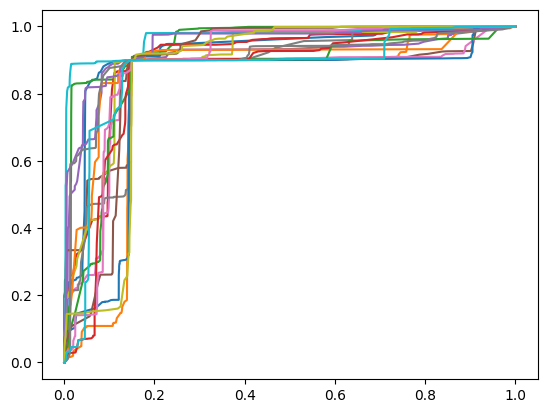

In [186]:
for idx in range(20):
    plt.plot(fprs[idx], tprs[idx])

In [141]:
aucs = [integrate_roc_curve(fpr, tpr) for fpr, tpr in zip(fprs, tprs)]
np.mean(aucs)

np.float64(0.2623352497568346)

In [124]:
fprs, tprs = sample2(0.024, 0.776, 300, 3000, 1000)

In [130]:

from mlscorecheck.auc import integrate_roc_curve, auc_min, auc_max

In [126]:
aucs = [integrate_roc_curve(fpr, tpr) for fpr, tpr in zip(fprs, tprs)]

In [127]:
"""for fpr, tpr in zip(fprs, tprs):
    plt.plot(fpr, tpr)"""

'for fpr, tpr in zip(fprs, tprs):\n    plt.plot(fpr, tpr)'

(array([ 29.,  87., 113., 133., 134., 139., 142., 108.,  81.,  34.]),
 array([0.79662978, 0.81553803, 0.83444629, 0.85335454, 0.8722628 ,
        0.89117105, 0.91007931, 0.92898756, 0.94789582, 0.96680407,
        0.98571233]),
 <BarContainer object of 10 artists>)

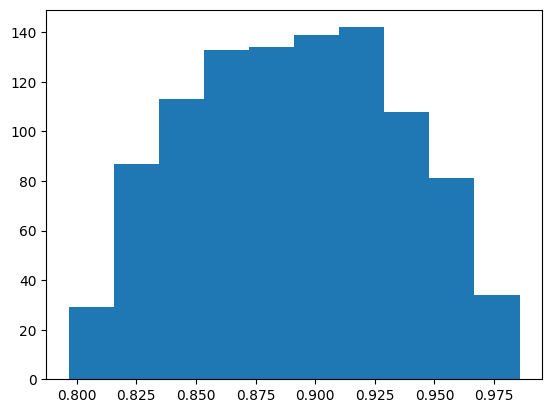

In [128]:
plt.hist(aucs)

In [129]:
np.mean(aucs)

np.float64(0.891373880488591)

In [131]:
(auc_min(0.024, 0.776) + auc_max(0.024, 0.776))/2

0.876

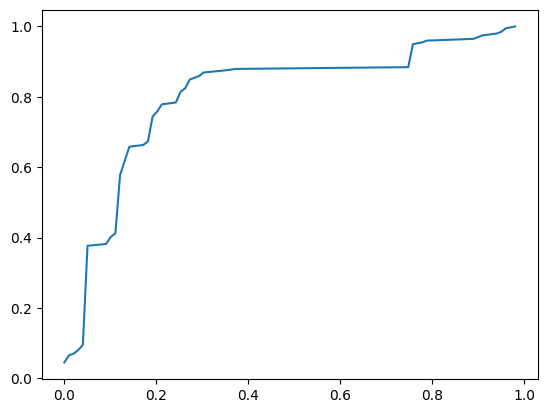

In [72]:
plt.plot(curve_fpr, curve_tpr)

In [3]:
x = np.linspace(0, 1, 1000)

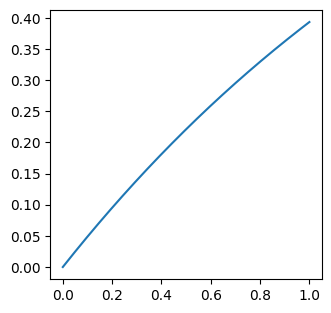

In [6]:
plt.figure(figsize=(3.5, 3.5))
plt.plot(x, 1 - np.exp(-0.5*x))

In [49]:
ress = []

for _ in range(1):
    fprs = np.cumsum(np.random.random_sample((1000, 10000)), axis=1)
    fprs = (fprs.T / (fprs[:, -1])).T
    lower_bounds = fprs
    upper_bounds = np.ones(fprs.shape)
    tprs = np.cumsum(np.random.random_sample((1000, 10000)), axis=1)
    tprs = (tprs.T / (tprs[:, -1])).T

    ress.append(np.sum((tprs[:, 1:] + tprs[:, :-1])/2*(fprs[:, 1:] - fprs[:, :-1]), axis=1))

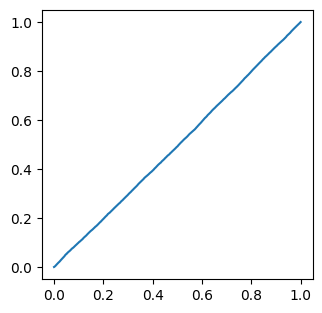

In [50]:
plt.figure(figsize=(3.5, 3.5))
plt.plot(fprs[100], tprs[100])

In [42]:
np.mean(np.hstack(ress))

np.float64(0.6665404626043141)

In [29]:
np.pi/4

0.7853981633974483

In [25]:
np.mean(res)

np.float64(0.7486049399116135)

In [22]:
1/np.mean(res)

np.float64(1.3602613016103413)

In [12]:
tpr = sp.Symbol('tpr', nonnegative=True)
fpr = sp.Symbol('fpr', nonnegative=True)
fracs = sp.Symbol('fracs', nonnegative=True)
y = sp.Symbol('y', nonnegative=True)
x = sp.Symbol('x', nonnegative=True)
p = sp.Symbol('p', nonnegative=True)

In [33]:
# implicit
print(sp.simplify(sp.diff((1.0 - (1 - x)**p - y**p)**2, p)))

2*(y**p*log(y) + (1 - x)**p*log(1 - x))*(y**p + (1 - x)**p - 1.0)


In [31]:
print(sp.simplify(sp.diff(sp.diff((1.0 - (1 - x)**p - y**p)**2, p), p)))

2*(y**p*log(y) + (1 - x)**p*log(1 - x))**2 + 2*(y**p*log(y)**2 + (1 - x)**p*log(1 - x)**2)*(y**p + (1 - x)**p - 1.0)


In [23]:
# explicit
print(sp.simplify(sp.diff(((1 - x**p)**(1/p) - y)**2, p)))

2*(y - (1 - x**p)**(1/p))*(p*x**p*log(x) - (x**p - 1)*log(1 - x**p))/(p**2*(1 - x**p)**((p - 1)/p))


In [28]:
print(sp.simplify(sp.diff(sp.diff(((1 - x**p)**(1/p) - y)**2, p), p)))

2*(p*(1 - x**p)**((2*p + 1)/p)*(y - (1 - x**p)**(1/p))*(p**2*x**(2*p)*log(x)**2 - p**2*x**p*(x**p - 1)*log(x)**2 + 2*p*x**p*(x**p - 1)*log(x) - 2*(x**p - 1)**2*log(1 - x**p)) + (1 - x**p)**(2 + 1/p)*(-y + 2*(1 - x**p)**(1/p))*(p*x**p*log(x) - (x**p - 1)*log(1 - x**p))**2)/(p**4*(x**p - 1)**4)


In [15]:
print((sp.diff(((1 - (1 - fracs)**p)**(1/p) - y)**2, p)))

2*(1 - (1 - fracs)**p)**(1/p)*(-y + (1 - (1 - fracs)**p)**(1/p))*(-(1 - fracs)**p*log(1 - fracs)/(p*(1 - (1 - fracs)**p)) - log(1 - (1 - fracs)**p)/p**2)


In [16]:
print(sp.diff((sp.diff(((1 - (1 - fracs)**p)**(1/p) - y)**2, p)), p))

2*(1 - (1 - fracs)**p)**(2/p)*(-(1 - fracs)**p*log(1 - fracs)/(p*(1 - (1 - fracs)**p)) - log(1 - (1 - fracs)**p)/p**2)**2 + 2*(1 - (1 - fracs)**p)**(1/p)*(-y + (1 - (1 - fracs)**p)**(1/p))*(-(1 - fracs)**p*log(1 - fracs)/(p*(1 - (1 - fracs)**p)) - log(1 - (1 - fracs)**p)/p**2)**2 + 2*(1 - (1 - fracs)**p)**(1/p)*(-y + (1 - (1 - fracs)**p)**(1/p))*(-(1 - fracs)**(2*p)*log(1 - fracs)**2/(p*(1 - (1 - fracs)**p)**2) - (1 - fracs)**p*log(1 - fracs)**2/(p*(1 - (1 - fracs)**p)) + 2*(1 - fracs)**p*log(1 - fracs)/(p**2*(1 - (1 - fracs)**p)) + 2*log(1 - (1 - fracs)**p)/p**3)


In [18]:
print(sp.diff((1 - x**p - y**p)**2, p))

(-2*x**p*log(x) - 2*y**p*log(y))*(-x**p - y**p + 1)


In [20]:
print(sp.diff(sp.diff((1 - x**p - y**p)**2, p), p))

(-2*x**p*log(x) - 2*y**p*log(y))*(-x**p*log(x) - y**p*log(y)) + (-2*x**p*log(x)**2 - 2*y**p*log(y)**2)*(-x**p - y**p + 1)


In [6]:
x = sp.Symbol('x', positive=True)
etpr = sp.Symbol('etpr', positive=True)
efpr = sp.Symbol('efpr', positive=True)

fpr = (1 - (1 - x)**efpr)**(1/efpr)
tpr = (1 - (1 - x)**etpr)**(1/etpr)

In [20]:
sp.simplify(sp.diff(tpr, etpr))

(1 - (1 - x)**etpr)**((1 - etpr)/etpr)*(-etpr*(1 - x)**etpr*log(1 - x) + ((1 - x)**etpr - 1)*log(1 - (1 - x)**etpr))/etpr**2

In [10]:
integrand = sp.simplify(fpr*sp.diff(tpr, x))
integrand

(1 - x)**(etpr - 1)*(1 - (1 - x)**efpr)**(1/efpr)*(1 - (1 - x)**etpr)**((1 - etpr)/etpr)

In [18]:
sp.diff(integrand, efpr).subs({efpr: 0})

nan

In [14]:
tmp = integrand.series(etpr, 0, 5)

O(etpr**5)


In [11]:
area = sp.integrate(integrand, (x, 0, 1))

KeyboardInterrupt: 

In [4]:
area

Integral(frac*(1 - frac)**etpr*(1 - (1 - frac)**etpr)**(1/etpr)/((frac - 1)*((1 - frac)**etpr - 1)), (frac, 0, 1))

In [38]:
frac = sp.Symbol('frac', nonnegative=True)
etpr = sp.Symbol('etpr', nonnegative=True)
efpr = sp.Symbol('efpr', nonnegative=True)

area = sp.integrate(frac**etpr * sp.diff((frac**efpr), frac), (frac, 0, 1))

In [39]:
area

Piecewise((-0**efpr*0**etpr*efpr/(efpr + etpr) + efpr/(efpr + etpr), Ne(efpr, -etpr)), (oo*sign(efpr), True))

In [23]:
area = sp.simplify(area)

In [24]:
area

Piecewise((efpr*(1 - 0**(efpr + etpr))/(efpr + etpr), Ne(efpr, -etpr)), (Piecewise((nan, Eq(efpr, 0)), (oo, True)), True))

In [31]:
print(area)

Piecewise((efpr*(1 - 0**(efpr + etpr))/(efpr + etpr), Ne(efpr, -etpr)), (Piecewise((nan, Eq(efpr, 0)), (oo, True)), True))


In [81]:
sp.simplify(area.subs({etpr: 0.3, efpr: 2}))

0.869565217391304

In [79]:
exp_tpr = 0.3
exp_fpr = 2

x = np.linspace(0, 1, 10000)

tprs = x**exp_tpr
fprs = x**exp_fpr

auc = float(np.sum((fprs[1:] - fprs[:-1])*(tprs[:-1] + tprs[1:])/2))
auc

0.8695652145025436

In [80]:
exp_fpr / (exp_tpr + exp_fpr)

0.8695652173913044

In [68]:
frac = sp.Symbol('frac', nonegative=True)
auc = sp.Symbol('auc', nonegative=True)
alpha = sp.Symbol('alpha', nonnegative=True)
beta = sp.Symbol('beta', nonnegative=True)
p = sp.Symbol('p', nonnegative=True)
n = sp.Symbol('n', nonnegative=True)

In [69]:
accpn = p*frac**((1 - auc)*alpha/auc) + n*(1 - frac**alpha)

In [70]:
np.array([accpn.subs({frac: f, p: 10, n: 20, auc: 0.8, alpha: 0.2})/(10 + 20) for f in np.linspace(0, 1, 100)])

array([2/3, 0.665637034439202, 0.635434374165001, 0.615246351265044,
       0.599680932699825, 0.586851145330147, 0.575853861764681,
       0.566180507478589, 0.557513947937874, 0.549641978846422,
       0.542415048662417, 0.535723476628751, 0.529484240443706,
       0.523632860768368, 0.518118180465285, 0.512898875679222,
       0.507941048614652, 0.503216520880315, 0.498701594836734,
       0.494376136075483, 0.490222881470168, 0.486226908978975,
       0.482375225581157, 0.478656442918197, 0.475060519016557,
       0.471578550469244, 0.468202603617577, 0.464925576212733,
       0.461741083141571, 0.458643361330168, 0.455627190063434,
       0.452687823796560, 0.449820935164307, 0.447022566373233,
       0.444289087529673, 0.441617160740943, 0.439003709049444,
       0.436445889434129, 0.433941069252307, 0.431486805605214,
       0.429080827199514, 0.426721018348511, 0.424405404815100,
       0.422132141246011, 0.419899499985943, 0.417705861092409,
       0.415549703398796, 0.4134295

In [71]:
d1 = sp.diff(accpn, frac)
d1

-alpha*frac**alpha*n/frac + alpha*frac**(alpha*(1 - auc)/auc)*p*(1 - auc)/(auc*frac)

In [78]:
np.array([d1.subs({frac: f, p: 10, n: 20, auc: 0.7, alpha: 10}) for f in np.linspace(0, 1, 10+20)])

array([0, 0.000671430727776516, 0.00654785887595145, 0.0248130753766740,
       0.0638518898426158, 0.132901220416834, 0.241843533555318,
       0.401005040177211, 0.620875481526835, 0.911659178457388,
       1.28254349864001, 1.74053877212077, 2.28870513117193,
       2.92353754044410, 3.63123074036548, 4.38249110033322,
       5.12550254420917, 5.77658880986794, 6.20804436037780,
       6.23253129074161, 5.58335957961173, 3.88988302554514,
       0.647153185822468, -4.82112139492220, -13.4073634173279,
       -26.2738203169101, -44.9164308564974, -71.2402477223493,
       -107.647919084194, -157.142857142857], dtype=object)

In [53]:
d2 = sp.diff(d1, frac)
d2

-alpha**2*frac**alpha*n/frac**2 + alpha**2*frac**(alpha*(1 - auc)/auc)*p*(1 - auc)**2/(auc**2*frac**2) + alpha*frac**alpha*n/frac**2 - alpha*frac**(alpha*(1 - auc)/auc)*p*(1 - auc)/(auc*frac**2)

In [57]:
np.array([d2.subs({frac: f, p: 10, n: 20, auc: 0.95, alpha: 0.2}) for f in np.linspace(0, 1, 100)])

array([nan, 11538.4150037392, 3347.91580657809, 1622.38344421851,
       970.093334689229, 650.904362435696, 469.771306043600,
       356.544958838928, 280.766250596410, 227.405161463269,
       188.321735292318, 158.783250983675, 135.879457535347,
       117.737667992925, 103.106725830192, 91.1238812263612,
       81.1779477834254, 72.8257441492970, 65.7393116924246,
       59.6715746832436, 54.4334129299568, 49.8779991228591,
       45.8898780809539, 42.3772113490447, 39.2661777673625,
       36.4968695096725, 34.0202427525954, 31.7958234121287,
       29.7899610105455, 27.9744855511527, 26.3256642048234,
       24.8233834781513, 23.4505026840119, 22.1923387842450,
       21.0362528708633, 19.9713159308427, 18.9880369349189,
       18.0781402747023, 17.2343825411948, 16.4504008692791,
       15.7205867637560, 15.0399806138224, 14.4041830961679,
       13.8092804361884, 13.2517810965690, 12.7285619329631,
       12.2368222277344, 11.7740443073215, 11.3379596838093,
       10.926519849

In [49]:
d2.subs({p:10, n:20, alpha: 0.3, frac: 0.1, auc: 0.5})

105.249319061727

In [45]:
sp.solve(sp.diff(acc, frac), frac)

[(p*(1 - auc)/(auc*n))**(auc/(alpha*(2*auc - 1)))]

In [ ]:
(p*(1 - auc)/(auc*n))**(auc/(alpha*(2*auc - 1)))